In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

***Data Cleaning and Exploration***

In [2]:
epi = pd.read_csv('data/dataframes/epi_wrangled.csv')

- Remove countries with fewer than 5 records.

In [3]:
high_data = [key for key, value in epi['country_name'].value_counts().to_dict().items() if value >5]

In [4]:
epi = epi[epi['country_name'].isin(high_data)]

In [5]:
epi['country_name'].value_counts()

North Macedonia     19
Timor-Leste         19
Namibia             19
Kazakhstan          19
Burkina Faso        19
                    ..
Maldives             9
Saint Lucia          9
Marshall Islands     9
Samoa                9
Micronesia           9
Name: country_name, Length: 185, dtype: int64

- Linearly impute values in place of nulls.

In [6]:
def impute_values(country_name):
    country = epi[epi['country_name'] == country_name].copy()
    for col in country.columns:
        country[col] = country[col].map(lambda x: np.nan if x == 'None' else x)
        country[col].interpolate(method='linear',order=1,inplace=True, axis=0)
    return country
        

In [7]:
epi_new = pd.DataFrame()

for country_name in  set(epi['country_name'].values):
    country_df = impute_values(country_name)
    epi_new = pd.concat([epi_new, country_df], ignore_index = True)

In [8]:
epi = epi_new

- Drop columns with low value data, identified by visual analysis with respect to time. These columns' values tend to be almost entirely the same for each country on the list.

In [9]:
drop_list = ['Climate','Forests', 'Critical Habitat Protection', 'Change in Forest Cover','Change of Trend in Carbon Intensity', 'Coastal Shelf Fishing Pressure',
'Trend in CO2 Emissions per KWH','Trend in Carbon Intensity','Climate & Energy']

In [10]:
epi.drop(columns=drop_list,inplace=True)

In [11]:
nulls = epi.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Marine Protected Areas                             868
Fish Stock Status                                  842
Fisheries                                          842
Agricultural Subsidies                             466
Ecosystem Vitality                                  38
Environmental Performance Index                     38
Water Resources                                     26
Wastewater Treatment                                26
GDP                                                 13
Environmental Health                                12
Child Mortality                                      9
Access to Electricity                                9
Health Impacts                                       9
Biodiversity & Habitat                               8
Terrestrial biome protection (global weights)        8
Agriculture                                          8
Terrestrial biome protection (national weights)      8
Air Quality                                          4
PM2.5 Exce

- Inspect columns with high null count indicators: Marine Protected Areas, Fisheries, Fish Stock Status and Agricultural Subsidies

In [12]:
def full_null_column(countries, column_name):
    all_null = []
    for country in countries:
        country_frame = epi[epi['country_name'] == country]
        nans = country_frame[column_name].isna().sum()

        if nans/country_frame.shape[0] == 1:
            all_null.append(country)
            
    return all_null

In [16]:
marine_countries = set(epi[epi['Marine Protected Areas'].isnull() == True]['country_name'].values)
fish_countries = set(epi[epi['Fisheries'].isnull() == True]['country_name'].values)
stock_countries = set(epi[epi['Fish Stock Status'].isnull() == True]['country_name'].values)

In [17]:
full_marine_nulls = full_null_column(marine_countries, 'Marine Protected Areas')
full_fishery_nulls = full_null_column(fish_countries, 'Fisheries')
full_stock_nulls = full_null_column(stock_countries, 'Fish Stock Status')

In [25]:
marine_anomalies = [country for country in marine_countries if country not in full_marine_nulls]
marine_anomalies

['Brunei Darussalam', 'Guinea-Bissau', 'Maldives']

In [26]:
fish_anomalies = [country for country in fish_countries if country not in full_fishery_nulls]
fish_anomalies

['Saint Vincent and the Grenadines']

In [27]:
stock_anomalies = [country for country in stock_countries if country not in full_stock_nulls]
stock_anomalies

['Saint Vincent and the Grenadines']

- Compare lists of countries.

In [22]:
full_marine_nulls[:5]

['Mali', 'Zimbabwe', 'Serbia', 'Niger', 'Dem. Rep. Congo']

In [23]:
full_fishery_nulls[:5]

['Mali', 'Zimbabwe', 'Serbia', 'Niger', 'Dem. Rep. Congo']

In [24]:
full_stock_nulls[:5]

['Mali', 'Zimbabwe', 'Serbia', 'Niger', 'Dem. Rep. Congo']

- All countries with null values for all three identifiers have been determined to be landlocked., and thus cannot have fisheries, marine protected areas, or fish stock status. Filling null values with 0.

In [28]:
landlocked = [x for x in marine_countries if x in fish_countries]

In [29]:
to_fill = ['Fisheries', 'Marine Protected Areas', 'Fish Stock Status']

In [30]:
for column in to_fill:
    epi.loc[epi['country_name'].isin(landlocked), column] = epi.loc[epi['country_name'].isin(landlocked), column].fillna(0)

- Inspect countries with poor marine data that are not landlocked.

In [31]:
marine_anomalies.extend(fish_anomalies)
anomalies = marine_anomalies

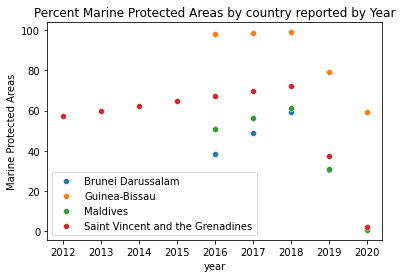

In [32]:
for country in anomalies:
    sns.scatterplot(data = epi[epi['country_name'] == country], x = 'year', y = 'Marine Protected Areas')

plt.legend(anomalies)
plt.title("Percent Marine Protected Areas by country reported by Year")
plt.show()

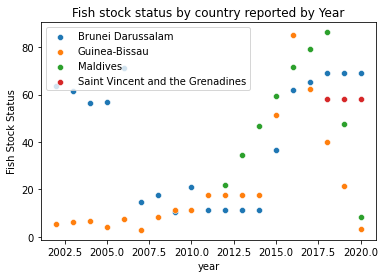

In [33]:
for country in anomalies:
    sns.scatterplot(data = epi[epi['country_name'] == country], x = 'year', y = 'Fish Stock Status')

plt.legend(anomalies)
plt.title("Fish stock status by country reported by Year")
plt.show()

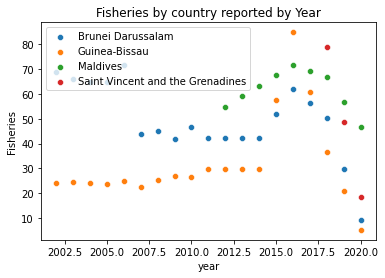

In [34]:
for country in anomalies:
    sns.scatterplot(data = epi[epi['country_name'] == country], x = 'year', y = 'Fisheries')

plt.legend(anomalies)
plt.title("Fisheries by country reported by Year")
plt.show()

- Decision: drop Saint Vincent and the Grenadines from our data, as we do not feel we can confidently impute null values from only three reported values in two categories (one of which shows significant volatility).

In [35]:
epi = epi[epi['country_name'] != 'Saint Vincent and the Grenadines']

- Inspect final column with high null count: Agricultural Subsidies.

In [36]:
ag_countries = set(epi[epi['Agricultural Subsidies'].isnull() == True]['country_name'].values)

In [37]:
full_ag_nulls = full_null_column(ag_countries, 'Agricultural Subsidies')

In [38]:
len(ag_countries) == len(full_ag_nulls)

True

- Impute regional values into each country. (TODO)

In [41]:
epi.loc[epi['country_name'].isin(ag_countries), 'Agricultural Subsidies'] = epi.loc[epi['country_name'].isin(ag_countries), 'Agricultural Subsidies'].fillna(-1)

C:\Users\Avanyali\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


- Inspect other less frequently null columns.

In [50]:
some_nulls = epi.isnull().sum().sort_values(ascending = False)
some_nulls = [column for column, value in some_nulls.items() if value > 0]

In [51]:
countries_present = {}
for column in some_nulls:
    null_countries = set(epi[epi[column].isnull() == True]['country_name'].values)
    for country in null_countries:
        if country in countries_present:
            countries_present[country] = countries_present[country] + 1
        else:
            countries_present[country] = 1

In [52]:
countries_present

{'Brunei Darussalam': 1,
 'Maldives': 10,
 'Guinea-Bissau': 1,
 'Samoa': 4,
 'Micronesia': 5,
 'Saint Lucia': 4,
 'Sao Tome and Principe': 7,
 'Marshall Islands': 6,
 'Iraq': 1,
 'Somalia': 1}

In [53]:
frequent_null_countries = [country for country, value in countries_present.items() if value > 1]

In [56]:
frequent_null_countries

['Maldives',
 'Samoa',
 'Micronesia',
 'Saint Lucia',
 'Sao Tome and Principe',
 'Marshall Islands']

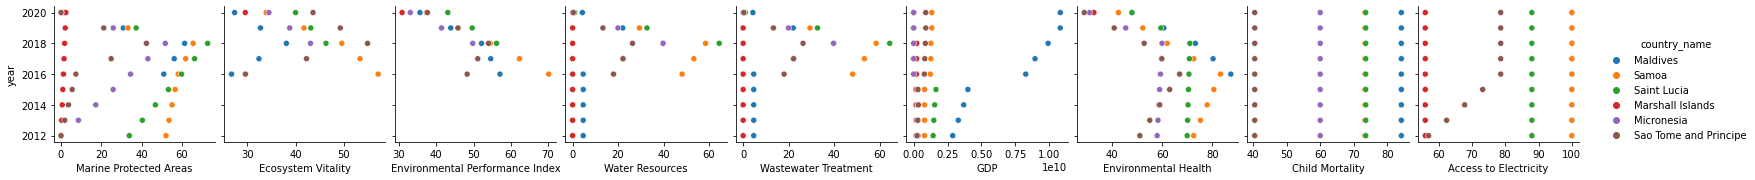

In [68]:
sns.pairplot(data = epi[epi['country_name'].isin(frequent_null_countries)], y_vars = 'year', x_vars = some_nulls[:9], hue = 'country_name')
plt.show()

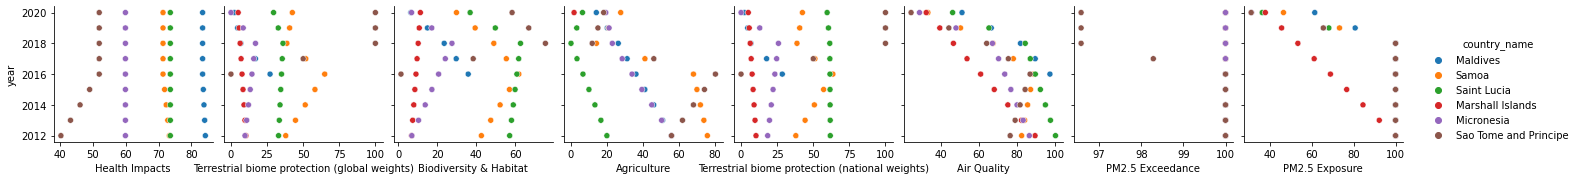

In [69]:
sns.pairplot(data = epi[epi['country_name'].isin(frequent_null_countries)], y_vars = 'year', x_vars = some_nulls[9:], hue = 'country_name')
plt.show()

- For similar reasons to the removal of Saint Vincent and the Grenadines, we are removing the Maldives, Samoa, Micronesia, Saint Lucia, the Marshall Islands, and Sao Tome and Principe from the data set. Reiteration of reasons: some categories contain too few non-null entries to confidently impute from, especially when some show high volatility.

In [77]:
epi = epi[~epi['country_name'].isin(frequent_null_countries)]

In [78]:
nulls = epi.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Marine Protected Areas    28
GDP                       13
dtype: int64

- Impute remaining nulls by padding using existing entries.

- TODO: Somalia?

In [81]:
epi[epi['GDP'].isnull() == True]

,year,country_name,Unsafe sanitation,Sanitation & Drinking Water,Terrestrial biome protection (national weights),PM2.5 Exposure,Unsafe drinking water,Water Resources,Ecosystem Vitality,Agriculture,...,Health Impacts,Household Air Quality,Access to Electricity,Pesticide Regulation,Agricultural Subsidies,Child Mortality,Fisheries,Marine Protected Areas,Fish Stock Status,GDP
503,2002,Somalia,2.14,1.07,3.43,100.00,0.00,3.96,6.04,50.0,...,14.01,2.6,26.6,0.0,100.0,14.01,0.0,0.0,0.0,NaN
504,2003,Somalia,2.18,1.09,3.43,100.00,0.00,3.96,6.04,50.0,...,14.41,2.9,26.9,0.0,100.0,14.41,0.0,0.0,0.0,NaN
505,2004,Somalia,2.21,1.11,3.43,100.00,0.00,3.96,6.04,50.0,...,14.82,3.2,27.2,0.0,100.0,14.82,0.0,0.0,0.0,NaN
506,2005,Somalia,2.25,1.13,3.43,100.00,0.00,3.96,6.04,50.0,...,15.25,3.5,27.5,0.0,100.0,15.25,0.0,0.0,0.0,NaN
507,2006,Somalia,2.30,1.15,3.43,100.00,0.00,3.96,6.04,50.0,...,15.71,3.8,27.8,0.0,100.0,15.71,0.0,0.0,0.0,NaN
508,2007,Somalia,2.35,1.18,3.43,100.00,0.00,3.96,6.04,50.0,...,16.18,4.1,28.1,0.0,100.0,16.18,0.0,0.0,0.0,NaN
509,2008,Somalia,2.41,1.20,3.43,100.00,0.00,3.96,6.04,50.0,...,16.65,4.4,28.4,0.0,100.0,16.65,0.0,0.0,0.0,NaN
510,2009,Somalia,2.47,1.23,3.43,100.00,0.00,3.96,6.04,50.0,...,17.11,4.7,28.7,0.0,100.0,17.11,0.0,0.0,0.0,NaN
511,2010,Somalia,2.52,1.26,3.43,100.00,0.00,3.96,6.50,56.0,...,17.58,5.0,29.0,12.0,100.0,17.58,0.0,0.0,0.0,NaN
512,2011,Somalia,2.58,1.29,3.43,100.00,0.00,3.96,6.50,56.0,...,18.06,5.0,29.0,12.0,100.0,18.06,0.0,0.0,0.0,NaN
